<a href="https://colab.research.google.com/github/JLoodts/4-on-a-row/blob/Generating-data-for-neural-net-training/00_FourOnARow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it a zoo or a wild animal?

Based on 'Is it a bird.' from https://github.com/fastai/course22/tree/master


I wanted to find a really though challenge for the neural net. The question whether an image of an animal is taken in the zoo or in the wild seemed a really though one to me. In this notebook we will create a neural network that is as good as possible in predicting this. This will take only a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "wild animal photos"
1. Use DuckDuckGo to search for images of "zoo animal photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a zoo animal and see if it works.

## Step 1: Download images of the categories

In order to easily preview the images and clean the datasets we story everything in our Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# modified from the original to solve ImportError: cannot import name 'ddg_images' from 'duckduckgo_search' (/usr/local/lib/python3.10/dist-packages/duckduckgo_search/__init__.py)
# solution from:  https://forums.fast.ai/t/lesson-1-official-topic/95287/608?u=jloodts
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
from PIL import Image
import numpy as np
import os

In [3]:
def saveBoards(data):
  # (number of boards, 126), where 126 = 6x7x3
  nrBoards = data.shape[0]
  folder = "/content/drive/MyDrive/4OnARow/input"

  from datetime import datetime
  now = datetime.now()
  time = now.strftime("%H%M%S.%f")[:-3]
  # save all images but the last one, these are all non victory
  for i in range(nrBoards-1):
    rgb_array = data[i].reshape((6, 7, 3))
    rgb_array = np.array(rgb_array, dtype=np.uint8)
    new_image = Image.fromarray(rgb_array)
    filename = f'{time}_{i:03d}.png'
    subfolder = folder + "/img"
    complete_path = os.path.join(subfolder, filename)
    new_image.save(complete_path)

  # save the last image, this is a victory
  i = nrBoards-1;
  rgb_array = data[i].reshape((6, 7, 3))
  rgb_array = np.array(rgb_array, dtype=np.uint8)
  new_image = Image.fromarray(rgb_array)
  filename = f'victory_{time}_{i:03d}.png'
  subfolder = folder + "/victoryimg"
  complete_path = os.path.join(subfolder, filename)
  new_image.save(complete_path)


In [34]:
def append_to_text():
  global text_to_save, my_game_cell
  for j in range(5, -1, -1):  # 6 rows because in the PNG, row 0 is at the top
    for i in range(7):  # 7 columns
      if my_game_cell[i][j] == 0:
        text_to_save += "0 0 0 "
      elif my_game_cell[i][j] == 1:  # human, red
        text_to_save += "255 0 0 "
      elif my_game_cell[i][j] == 2:  # computer, yellow
        text_to_save += "255 255 0 "
      else:
        raise ValueError("Wrong value in append_to_text()")
  text_to_save += "\n"

In [26]:
def save_to_file(text_to_save, filename):
  # Assuming my_game_cell and text_to_save are defined elsewhere
  blob = bytes(text_to_save, 'utf-8')
  with open(filename, 'wb') as file:
    file.write(blob)

In [6]:
def initialize_game():
  # Initialize myGameCell to 0 and draw cells
  global my_game_cell
  for i in range(7):  # 7 columns
    for j in range(6):  # 6 rows
      my_game_cell[i][j] = 0  # all cells are empty

In [7]:
def get_free_row(column_nr, matrix):
  # Returns -1 when there is no free row, otherwise the return value is the first free row that was found for that column
  for j in range(6):  # 6 rows
    if matrix[column_nr][j] == 0:
      return j
  return -1

In [8]:
import random

def find_next_move():
  global my_game_cell, myGamePlayer
  # Copy the matrix
  free_row_in_column = []
  matrix = []
  for i in range(7):  # 7 columns
    matrix.append([my_game_cell[i][j] for j in range(6)])

  for i in range(7):  # 7 columns
    free_row_in_column.append(get_free_row(i, matrix))

  # Make a random move with preference for center
  random_choice = random.randint(0, 4)
  if random_choice == 0:
    index = [3, 2, 4, 5, 1, 6, 0]
  elif random_choice == 1:
    index = [4, 2, 3, 5, 6, 1, 0]
  elif random_choice == 2:
    index = [2, 3, 4, 5, 0, 6, 1]
  elif random_choice == 3:
    index = [3, 5, 4, 1, 2, 6, 0]
  elif random_choice == 4:
    index = [4, 3, 2, 0, 1, 6, 5]
  else:
    index = [3, 2, 4, 5, 1, 6, 0]

  for i in range(7):  # 7 columns
    next_col = index[i]
    next_row = get_free_row(next_col, my_game_cell)
    if next_row != -1:  # Column nextMove isn't full yet
      my_game_cell[next_col][next_row] = myGamePlayer
      return next_col

  print("The computer couldn't find a valid move. Congratulations, it's a tie game.")

In [9]:
def check_four_on_a_row(matrix):
  result = []

  # Check horizontal
  for j in range(6):  # 6 rows
    for i in range(7 - 3):  # 7 columns
      max_val = max(matrix[i][j], matrix[i + 1][j], matrix[i + 2][j], matrix[i + 3][j])
      min_val = min(matrix[i][j], matrix[i + 1][j], matrix[i + 2][j], matrix[i + 3][j])
      if max_val == min_val and max_val != 0:  # We have a winner
        result.append(i)

  # Check vertical
  for i in range(7):  # 7 columns
    for j in range(6 - 3):  # 6 rows
      max_val = max(matrix[i][j], matrix[i][j + 1], matrix[i][j + 2], matrix[i][j + 3])
      min_val = min(matrix[i][j], matrix[i][j + 1], matrix[i][j + 2], matrix[i][j + 3])
      if max_val == min_val and max_val != 0:  # We have a winner
        result.append(i)

  # Check diagonal right-up
  for i in range(7 - 3):  # 7 columns
    for j in range(6 - 3):  # 6 rows
      max_val = max(matrix[i][j], matrix[i + 1][j + 1], matrix[i + 2][j + 2], matrix[i + 3][j + 3])
      min_val = min(matrix[i][j], matrix[i + 1][j + 1], matrix[i + 2][j + 2], matrix[i + 3][j + 3])
      if max_val == min_val and max_val != 0:  # We have a winner
          result.append(i)

  # Check diagonal left-up
  for i in range(3, 7):  # 7 columns
    for j in range(6 - 3):  # 6 rows
      max_val = max(matrix[i][j], matrix[i - 1][j + 1], matrix[i - 2][j + 2], matrix[i - 3][j + 3])
      min_val = min(matrix[i][j], matrix[i - 1][j + 1], matrix[i - 2][j + 2], matrix[i - 3][j + 3])
      if max_val == min_val and max_val != 0:  # We have a winner
        result.append(i)

  return result


In [35]:
# 1st step :: let the computer play nrGamesToPlay games against itself and for each game save the recorded board states in a txt file
my_game_cell = [[0] * 6 for _ in range(7)]
myGamePlayer = 1
nrGamesToPlay = 100

filename = '/content/drive/MyDrive/4OnARow/bronbestanden/pixels.txt'
for m in range(1, nrGamesToPlay):
  filename = f'/content/drive/MyDrive/4OnARow/bronbestanden/pixels({m}).txt'
  text_to_save = ""
  initialize_game()
  for n in range(7*6):
    find_next_move()
    append_to_text()
    # switch player after move
    if myGamePlayer == 1:
      myGamePlayer = 2
    else:
      myGamePlayer = 1
    winning_move = check_four_on_a_row(my_game_cell)
    if len(winning_move) >= 1:
      save_to_file(text_to_save, filename)
 #     print("Save victoryimg")
      break
 #   else:
      #print("Save img")


In [36]:
# 2nd step :: use this code to read the text files and save the corresponding png's
for n in range(1, nrGamesToPlay):
  # Specify the filename (change to your actual file path)
  # each line represents a board situation (7 columns, 6 rows, (R,G,B)-value of the player's colour)
  # 1 = human = red (255,0,0)
  # 2 = computer = yellow (255,255,0)
  # row 0 in png = row 5 in board
  filename = f'/content/drive/MyDrive/4OnARow/bronbestanden/pixels({n}).txt'

  # Load data from the text file (assuming space-separated values)
  # all values are floats
  data = np.loadtxt(filename)
  saveBoards(data)

...and then download a URL and take a look at it:

In [37]:
dest = '/content/drive/MyDrive/4OnARow/input/victoryimg/victory_100450.902_014.png'

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "wild animal photos":

In [39]:
dest = '/content/drive/MyDrive/4OnARow/input/img/100450.902_002.png'
Image.open(dest).to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each, and save each group of photos to a different folder:

In order to supplement the dataset we manually add some good search prompts, review the results in Google Drive and add the best ones to the appropriate dataset folder.

after the manual step above we need to resize all new images

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [40]:
path = Path('/content/drive/MyDrive/4OnARow/input')

In [41]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

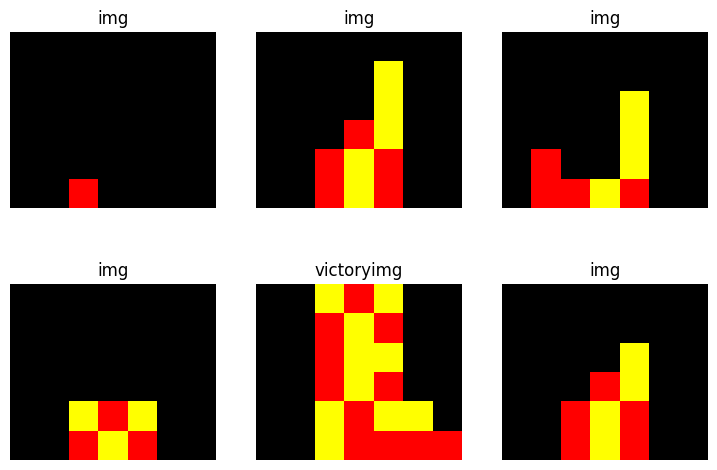

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    #item_tfms=[Resize(7, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.393371,0.752054,0.770833,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.109487,0.598796,0.125000,00:01
1,1.151968,0.662951,0.312500,00:01
2,1.103110,0.827970,0.812500,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

SuggestedLRs(valley=0.0030199517495930195)

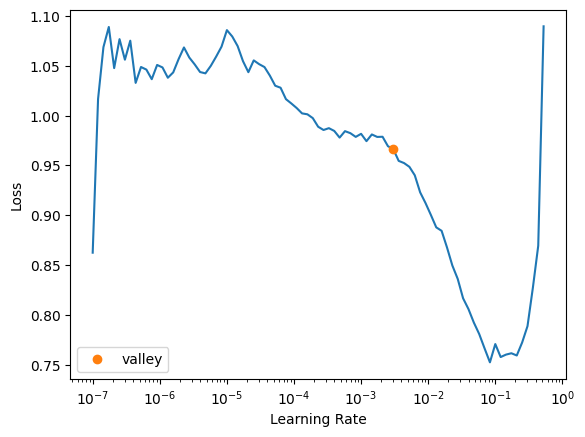

In [ ]:
learn.lr_find()


In [ ]:
learn.fine_tune(5, 6e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.397282,0.465551,0.020833,00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,2.444522,4.803551,0.979167,00:01
1,1.677132,0.135802,0.041667,00:01
2,1.247931,0.374235,0.062500,00:01
3,1.006881,0.382044,0.104167,00:01
4,0.853326,0.154967,0.041667,00:01


## Step 3: Use our model (and build your own!)

The predict method returns three things: the decoded prediction, the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed label. This method accepts a filename, a PIL image or a tensor directly in this case.

Let's see what our model thinks about the images we downloaded at the start:

In [ ]:
category,categoryIndex,probs = learn.predict(PILImage.create('/content/drive/MyDrive/4OnARow/test/161331.675_008.png'))
print(f"This is a: {category}.")
print(f"Probability it's a img: {probs[0]:.4f}")

This is a: img.
Probability it's a img: 0.9629


In [ ]:
learn.predict(PILImage.create('/content/drive/MyDrive/4OnARow/test/victory_161331.675_009.png'))

('img', tensor(0), tensor([0.9619, 0.0381]))

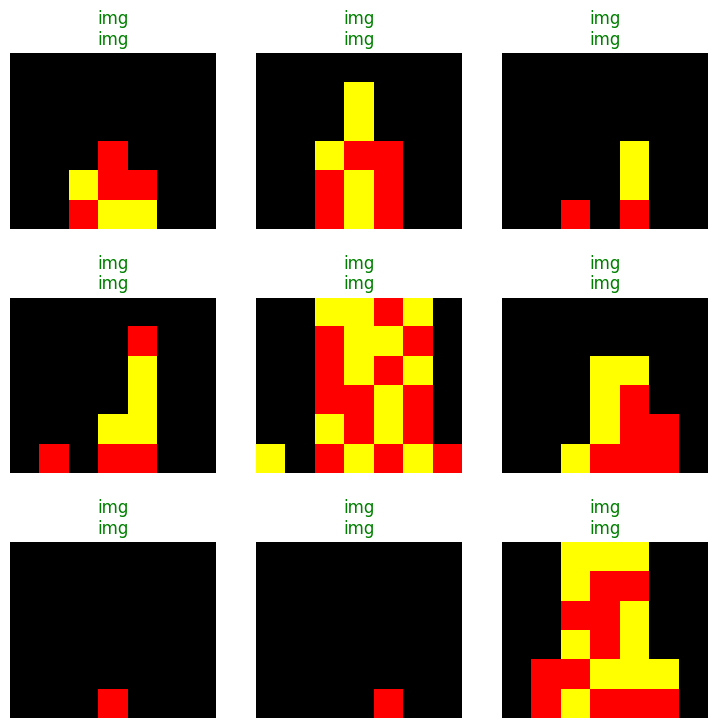

In [ ]:
learn.show_results()

Another thing that is useful is an interpretation object, it can show us where the model made the worse predictions:

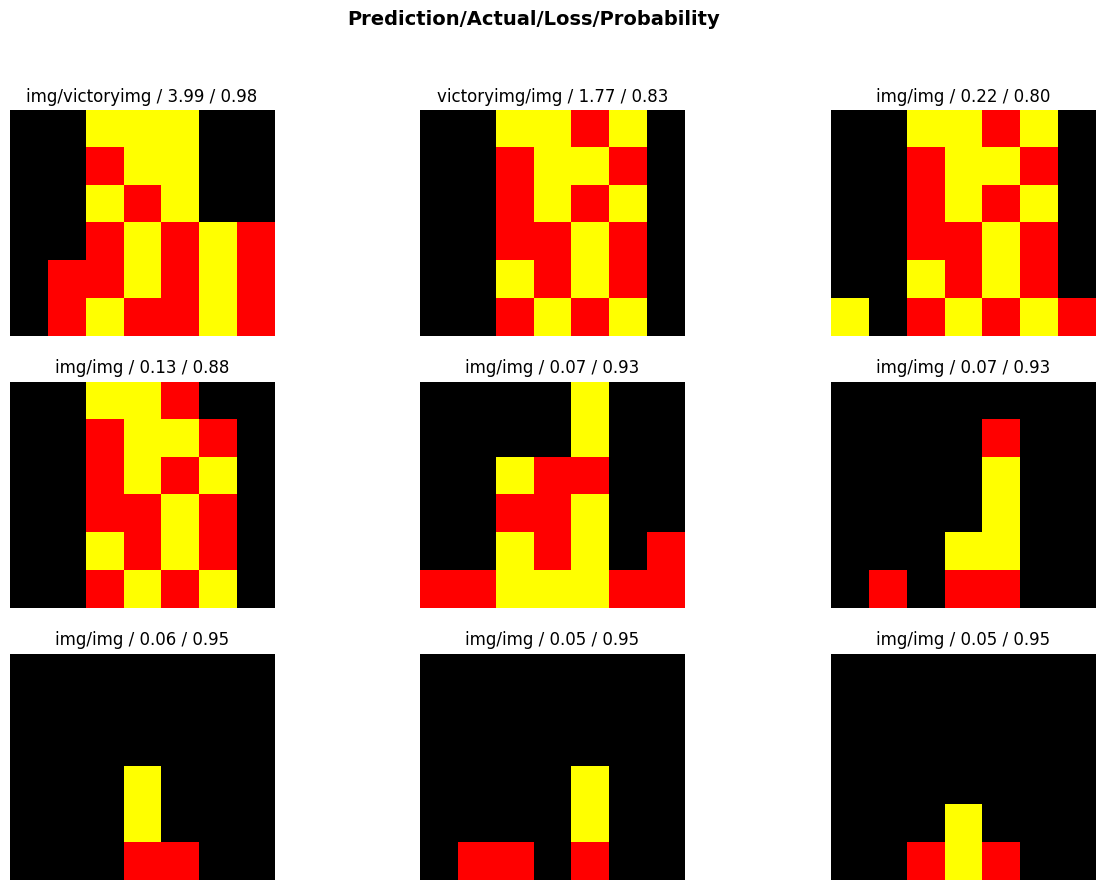

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))